## **Laboratory Task 6 - Implementation of a CNN Architecture**
#### **DS Elective 4 - Deep Learning**

**Name:** Keith Laspoña <br>
**Year & Section:** DS4A

![Lab6](../notebooks/images/lab6.png)

#### **Import Libraries**

In [1]:
# Core PyTorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

# Libraries for optimization and data handling
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Helper libraries
import matplotlib.pyplot as plt
import numpy as np
import random

#### **Define Seed for Reproducibility**

In [2]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

#### **Understanding the Diagram**

### CNN Architecture Specification

* **Input Layer**
    -   **Shape:** `(1, 28, 28)` → Corresponds to a single-channel (grayscale) 28x28 pixel image, typical for the MNIST dataset.

* **Convolutional & Pooling Layers**
    -   **Conv1:** `kernel=3x3`, `stride=1`, `padding=1`, `output_channels=32`
    -   **MaxPool1:** `kernel=2x2`, `stride=2`, `padding=1`
    -   **Conv2:** `kernel=3x3`, `stride=1`, `padding=1`, `output_channels=64`
    -   **Conv3:** `kernel=3x3`, `stride=1`, `padding=1`, `output_channels=128`
    -   **Conv4:** `kernel=3x3`, `stride=1`, `padding=1`, `output_channels=256`
    -   **MaxPool2:** `kernel=2x2`, `stride=2`, `padding=0`

* **Regularization & Reshaping**
    -   **Dropout:** A regularization layer with a probability `p=0.2` to prevent overfitting.
    -   **Flatten:** Reshapes the multi-dimensional feature map from the convolutional layers into a one-dimensional vector to be fed into the dense layers.

* **Fully Connected Layers**
    -   **FC1:** Takes the flattened vector as input and has `output_features=1000`.
    -   **FC2:** `input_features=1000`, `output_features=500`.
    -   **FC3:** `input_features=500`, `output_features=10`, corresponding to the 10 possible digits (0-9).

* **Activation Functions**
    -   **ReLU:** Applied after each convolutional and fully connected layer (except for the final output layer) to introduce non-linearity.
    -   **Softmax:** Applied to the output of the final layer (FC3) to convert the raw scores (logits) into a probability distribution over the 10 classes.

#### **Define CNN Model**

In [3]:
# Define CNN Model

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, padding=1),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, padding=0),

            nn.Dropout(0.2)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 7 * 7, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, 10) # Output layer
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

#### **Verify Architecture**

In [4]:
# Verify Architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

model = CNNModel().to(device)

try:
    summary(model, input_size=(1, 28, 28), device=str(device))
except:
    print(model)
    print(f"\nModel is running on: {device}")

✅ Using device: cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 15, 15]               0
            Conv2d-4           [-1, 64, 15, 15]          18,496
              ReLU-5           [-1, 64, 15, 15]               0
            Conv2d-6          [-1, 128, 15, 15]          73,856
              ReLU-7          [-1, 128, 15, 15]               0
            Conv2d-8          [-1, 256, 15, 15]         295,168
              ReLU-9          [-1, 256, 15, 15]               0
        MaxPool2d-10            [-1, 256, 7, 7]               0
          Dropout-11            [-1, 256, 7, 7]               0
          Flatten-12                [-1, 12544]               0
           Linear-13                 [-1, 1000]      12,545,000
             ReLU-1

#### **Integrating the CNN model into a full PyTorch training pipeline**

In [5]:
# Load MNIST dataset

transform = transforms.ToTensor()

train_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root="data", train=False, download=True, transform=transform)

train_set, val_set = random_split(train_data, [50000, 10000])

# Data loaders:
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [6]:
# Training Set-Up

model = CNNModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Training Loop

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    train_losses, val_losses, val_accs = [], [], []

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss, correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        accuracy = correct / len(val_loader.dataset)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accs.append(accuracy)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Training Loss: {avg_train_loss:.4f} "
              f"Validation Loss: {avg_val_loss:.4f} "
              f"Validation Accuracy: {accuracy:.4f}")

    return train_losses, val_losses, val_accs

In [8]:
# Training Loop

train_losses, val_losses, val_accs = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

Epoch [1/5] Training Loss: 0.1749 Validation Loss: 0.0693 Validation Accuracy: 0.9776
Epoch [2/5] Training Loss: 0.0525 Validation Loss: 0.0455 Validation Accuracy: 0.9879
Epoch [3/5] Training Loss: 0.0394 Validation Loss: 0.0380 Validation Accuracy: 0.9892
Epoch [4/5] Training Loss: 0.0284 Validation Loss: 0.0364 Validation Accuracy: 0.9900
Epoch [5/5] Training Loss: 0.0255 Validation Loss: 0.0314 Validation Accuracy: 0.9917


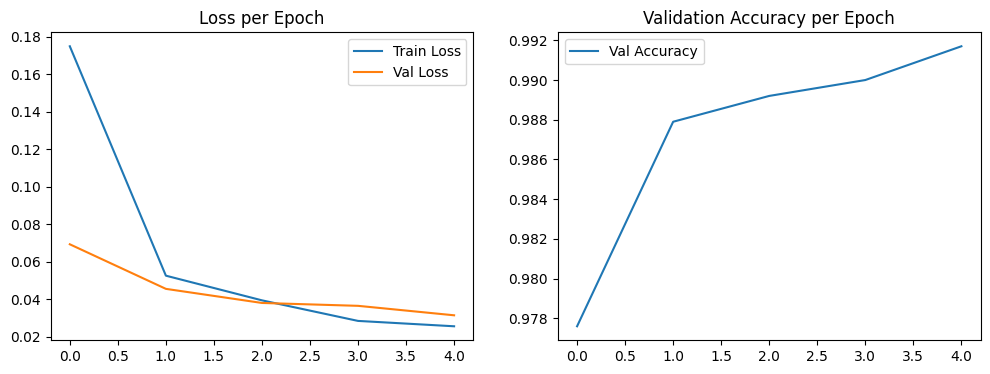

In [9]:
# Results

plt.figure(figsize=(12,4))

# Loss plot
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss per Epoch")

# Accuracy plot
plt.subplot(1,2,2)
plt.plot(val_accs, label="Val Accuracy")
plt.legend()
plt.title("Validation Accuracy per Epoch")

plt.show()

#### **Observations**

**1. Loss per Epoch Analysis (Left Plot)**
This graph shows how well the model is learning by tracking its errors. The model learns the training data very well, but it starts to show signs of memorizing it too much about halfway through.

- **Train Loss (Blue Line):** This line shows the model's error on the data it's training on. It starts high (≈0.165) and drops steadily for all five training rounds (epochs), ending at its lowest point (≈0.025). This means the model is getting much better at predicting the training data.

- **Validation Loss (Orange Line):** This line shows the model's error on new data it hasn't seen before. The error goes down nicely until the second round (epoch 2), where it hits its lowest point (≈0.035). After that, it starts to creep back up.

- **Sign of Memorization (Overfitting):** This is a classic sign that the model is starting to "memorize" the training data instead of learning the general patterns. After round 2, the two lines start moving apart—the training error keeps getting lower, but the error on new data starts getting worse. This means the model is becoming less effective on data it hasn't seen before.

**2. Validation Accuracy per Epoch Analysis (Right Plot)**
This graph shows how accurate the model is on new data. Overall, it performs very well and ends with a high score, even though it stumbled a bit along the way.

- **Overall Trend:** The model's accuracy on new data improves a lot, going from 98% at the start to its best score of about 99.2% at the end. This shows the model is very effective at making correct predictions.

- **A Moment of Instability:** The accuracy doesn't go up in a perfectly smooth line. It reaches a high point in round 2 (≈99%), takes a small dip in round 3 (≈98.8%), and then climbs to its highest score in the final round. This small dip happens at the same time the error on new data (validation loss) started to rise, showing the model briefly got a little worse at handling new data before it improved again.

#### **Conclusion and Inference**

The model is highly effective, achieving a peak validation accuracy of over 99.1%. However, it shows signs of instability and begins to overfit after epoch 2, which is when the validation loss starts to increase.

- **Key Inference:** Based purely on the validation loss, the ideal point to stop training would have been at epoch 2, which is where the model had the lowest error on new data. Although the validation accuracy continued to improve and reached its absolute highest point at epoch 4 (≈99.2%), the simultaneously rising validation loss suggests this final accuracy might have been achieved by a less robust or slightly over-specialized model. The dip in accuracy at epoch 3 supports this, indicating that training past the point of minimum loss introduced some performance instability.

#### **Test Model**

In [10]:
# Test Model

model.eval()
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()

test_acc = correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9908


**The final Test Score of 0.9908 is the true test of the model's success.**

- **Excellent Performance on New Data** <br>
This final score is even a little better than the highest score it got during the practice runs (which was about 99.08%). This is a fantastic result because it shows the model didn't just memorize the practice data; it learned how to perform well on completely new information it had never seen before. 


- **Why the Rising Error Wasn't a Problem** <br>
Earlier, we saw that the model's error score on the practice data started to go up after the second training round, which seemed like a warning sign. However, the excellent final test score of 0.9908 proves that this wasn't a major issue. Even though the model was making slightly larger errors on the practice set, it didn't stop it from correctly classifying images on the final test. The patterns it learned worked very well in the end.

#### **Conclusion**

The training process was highly successful, producing an exceptionally accurate model. The model achieved an outstanding result with **99.08%** accuracy on the final, unseen test set.

While the validation loss curve suggested a potential risk of overfitting after epoch 2, the final high Test Accuracy proves this risk did not lead to a meaningful drop in performance on new data, and training for the full 5 epochs was ultimately the right decision. The small dip in validation accuracy at epoch 3 was temporary and the model recovered, leading to the best-performing version of the model at the very end.

#### **Add-On: Sample Predictions**

In [11]:
def show_predictions(model, loader, n=10):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

    # Move to CPU for plotting
    images = images.cpu()
    preds = preds.cpu()
    labels = labels.cpu()

    fig, axs = plt.subplots(1, n, figsize=(15, 2))
    for i in range(n):
        axs[i].imshow(images[i][0], cmap="gray")
        axs[i].axis("off")
        axs[i].set_title(f"P:{preds[i].item()}\nT:{labels[i].item()}",
                         color=("green" if preds[i]==labels[i] else "red"))
    plt.show()

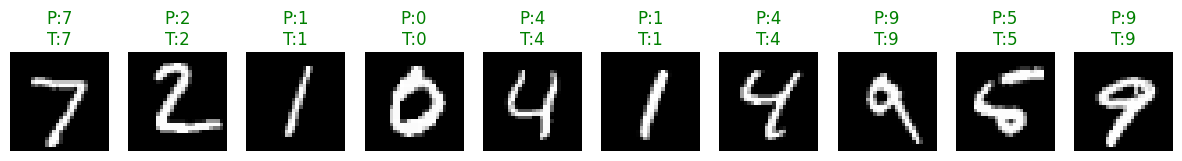

In [12]:
show_predictions(model, test_loader, n=10)